
===== Cycle 1 / 2 =====


<Figure size 1000x700 with 0 Axes>

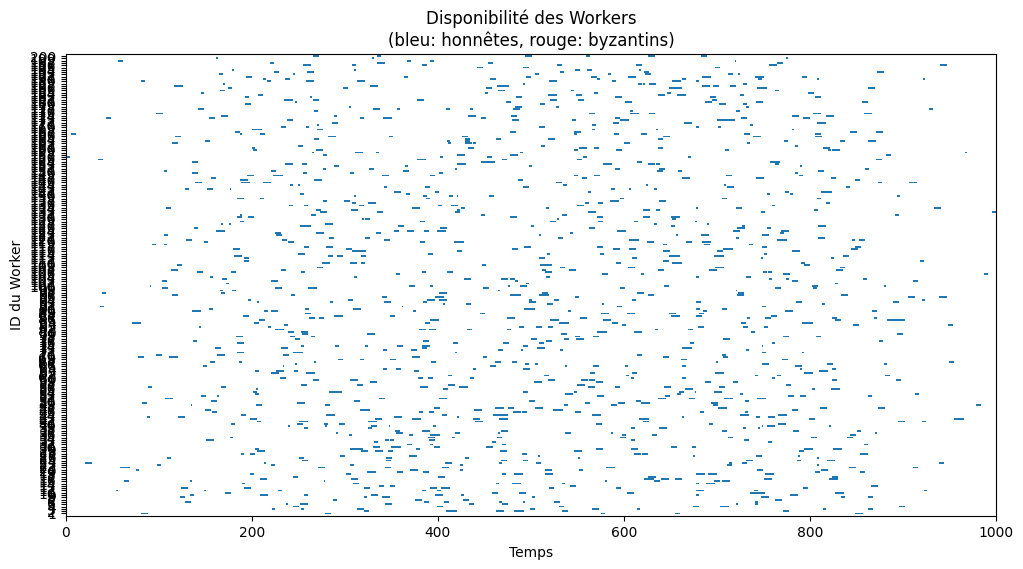

Nombre de mises à jour du modèle durant le cycle : 12


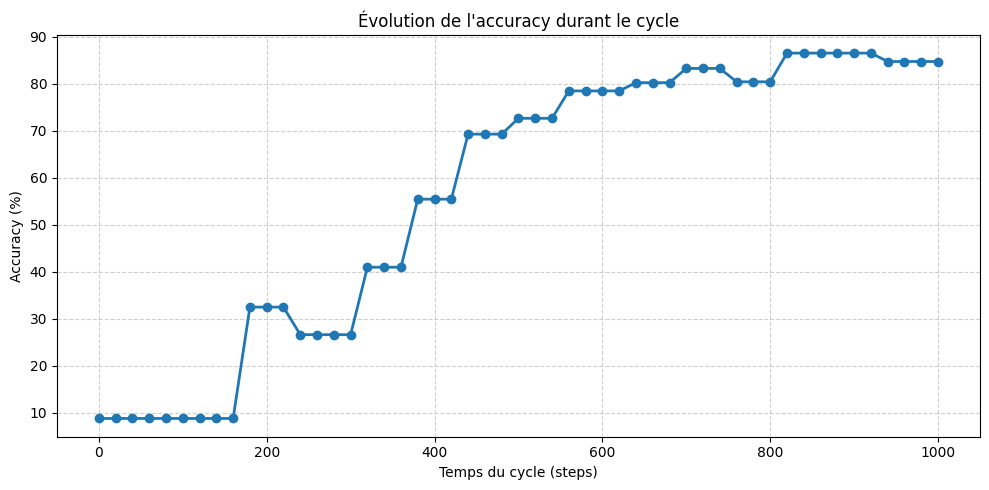

Accuracy finale du cycle : 84.73%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 3647
- Temps de calcul utile        : 295
- Temps de calcul gaspillé     : 3342
- Taux de gaspillage           : 91.64%


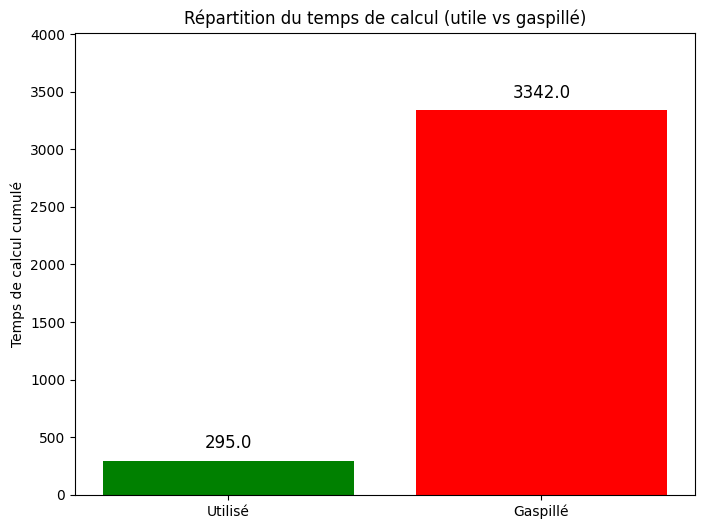


===== Cycle 2 / 2 =====


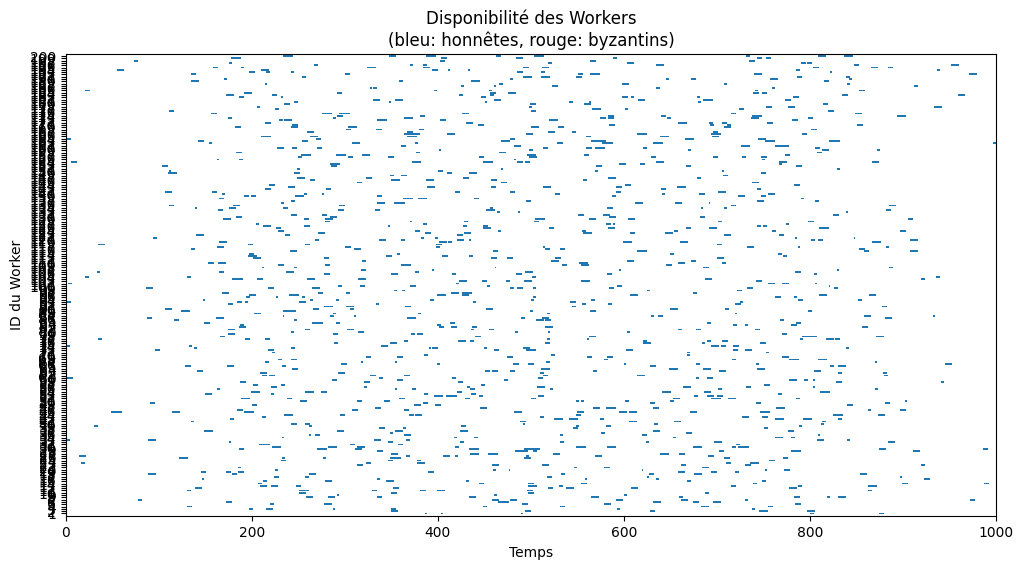

Nombre de mises à jour du modèle durant le cycle : 11


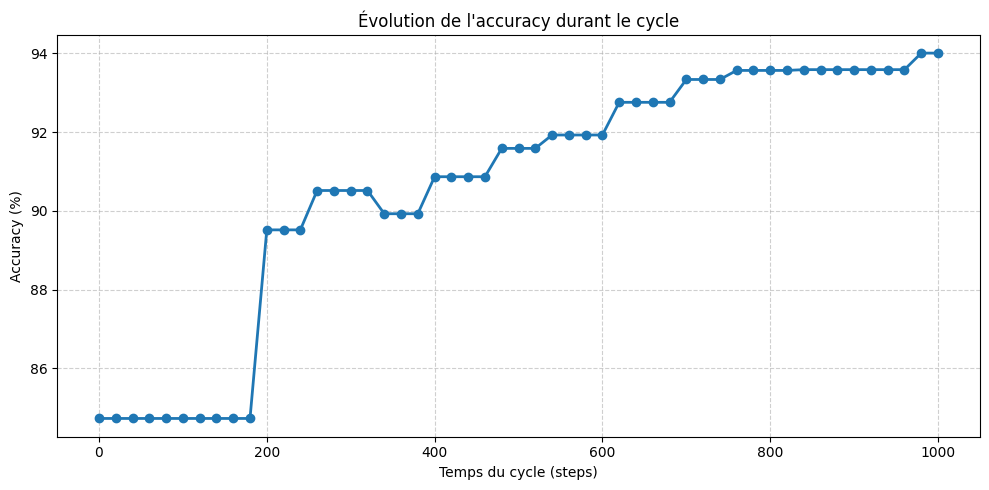

Accuracy finale du cycle : 94.01%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 7211
- Temps de calcul utile        : 579
- Temps de calcul gaspillé     : 6603
- Taux de gaspillage           : 91.57%


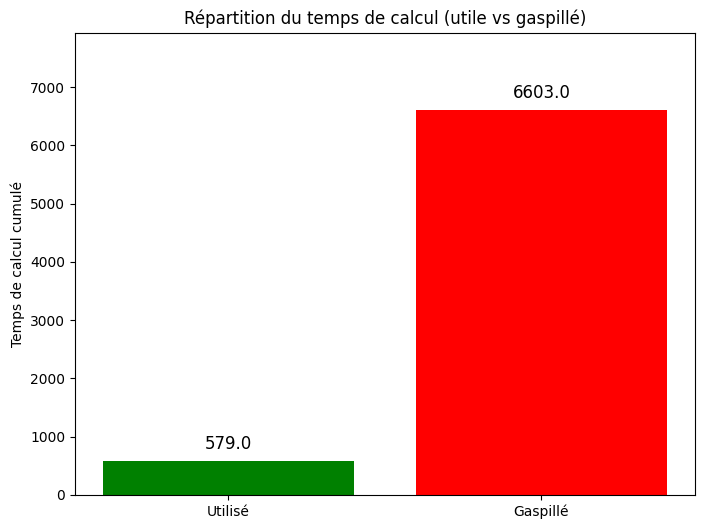

Run final - Accuracy après 2 cycles : 94.01%

Accuracy moyenne sur tous les runs : 94.01%
PreAgg: NoPreAgg, Aggregator: average, Byzantine ratio: 0%, Accuracy: 94.01%

===== Cycle 1 / 2 =====


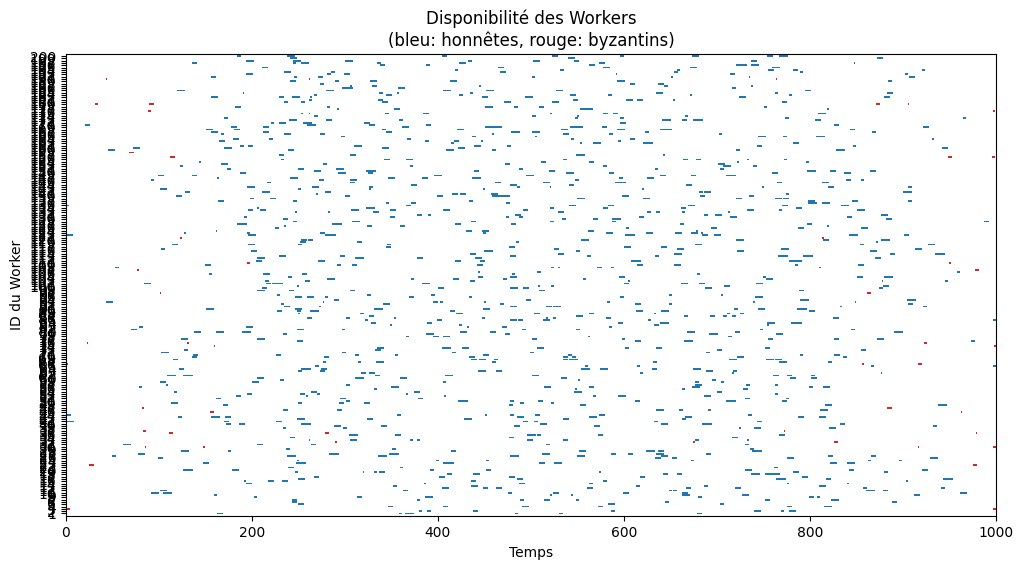

Nombre de mises à jour du modèle durant le cycle : 11


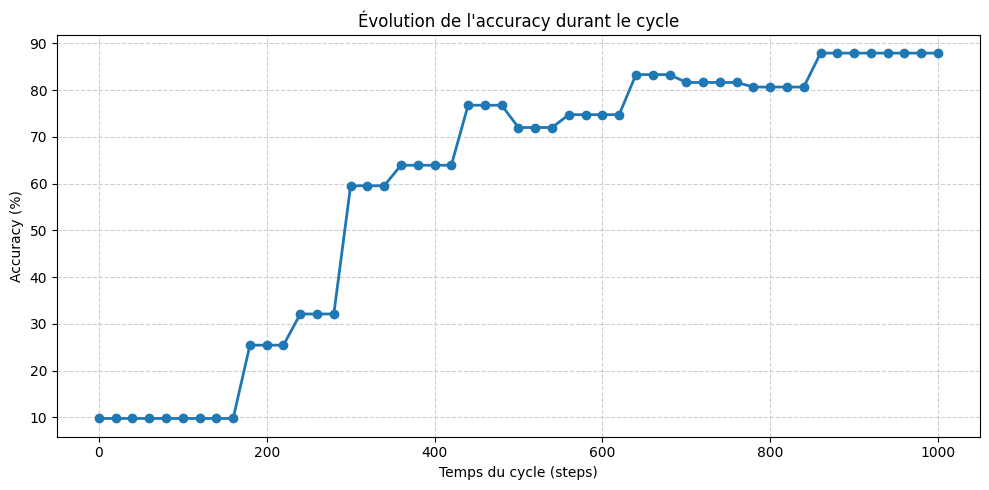

Accuracy finale du cycle : 87.92%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 3561
- Temps de calcul utile        : 289
- Temps de calcul gaspillé     : 3268
- Taux de gaspillage           : 91.77%


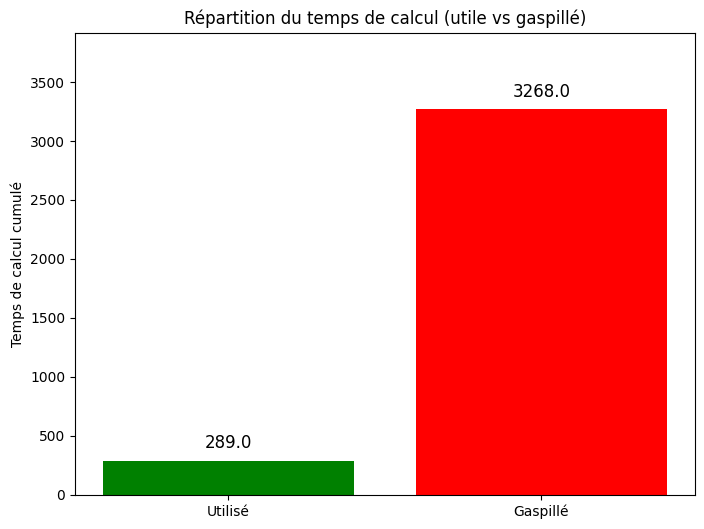


===== Cycle 2 / 2 =====


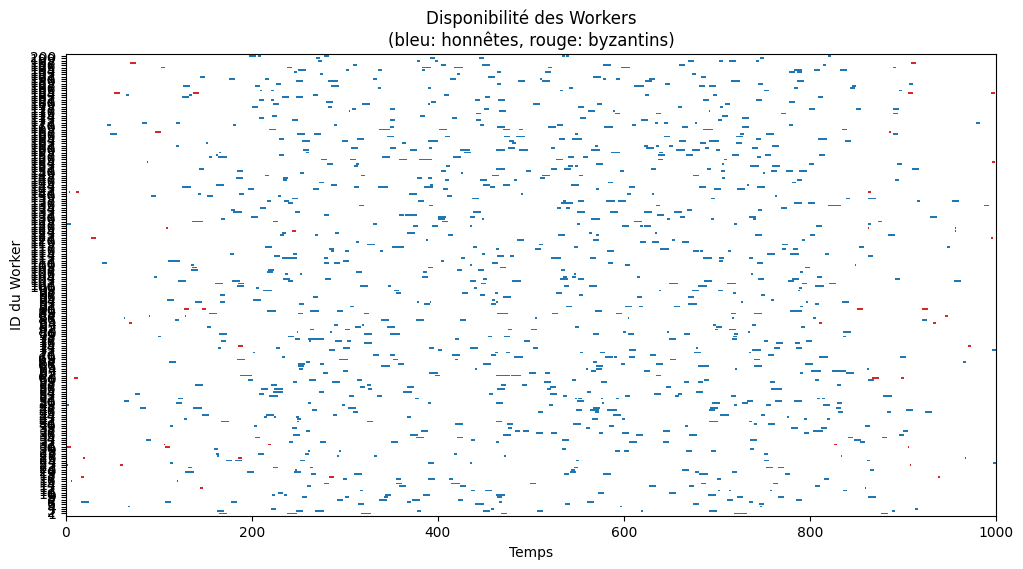

Nombre de mises à jour du modèle durant le cycle : 11


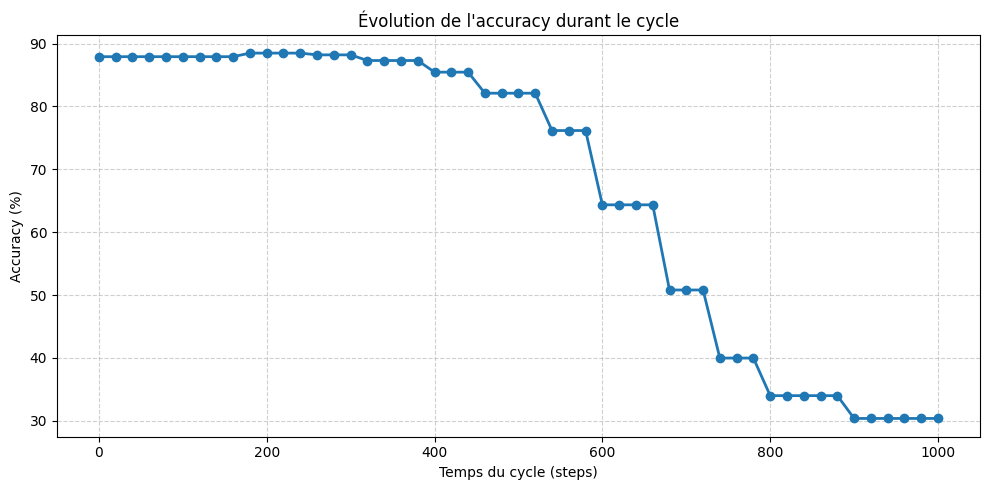

Accuracy finale du cycle : 30.36%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 6984
- Temps de calcul utile        : 573
- Temps de calcul gaspillé     : 6392
- Taux de gaspillage           : 91.52%


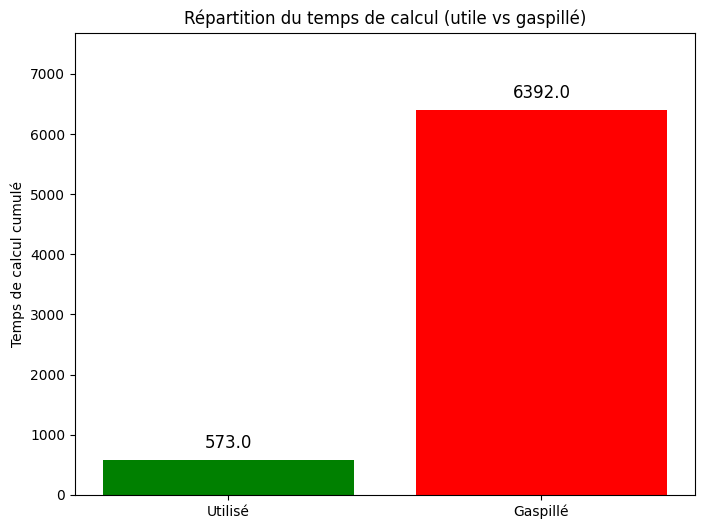

Run final - Accuracy après 2 cycles : 30.36%

Accuracy moyenne sur tous les runs : 30.36%
PreAgg: NoPreAgg, Aggregator: average, Byzantine ratio: 10%, Accuracy: 30.36%

===== Cycle 1 / 2 =====


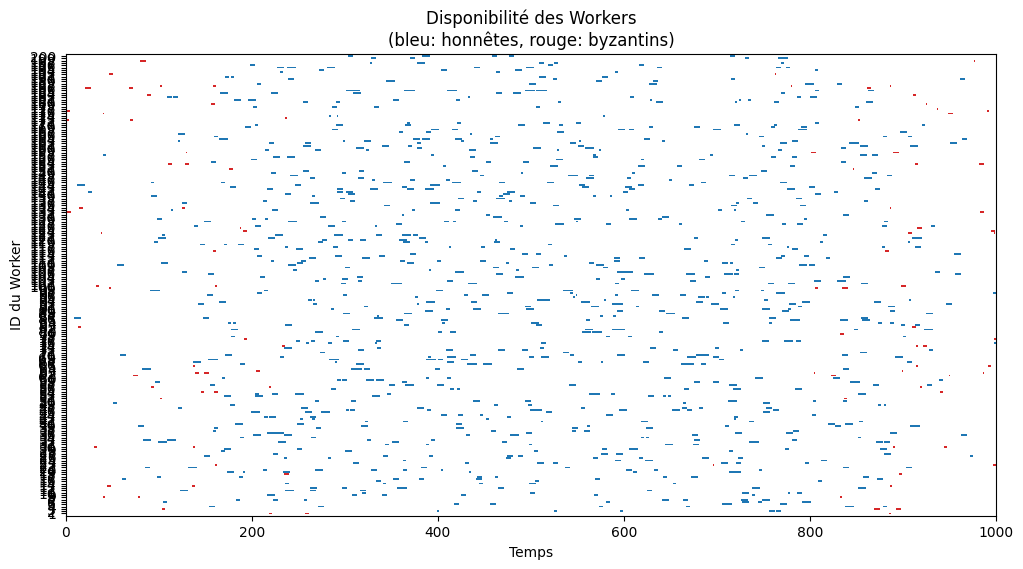

Nombre de mises à jour du modèle durant le cycle : 9


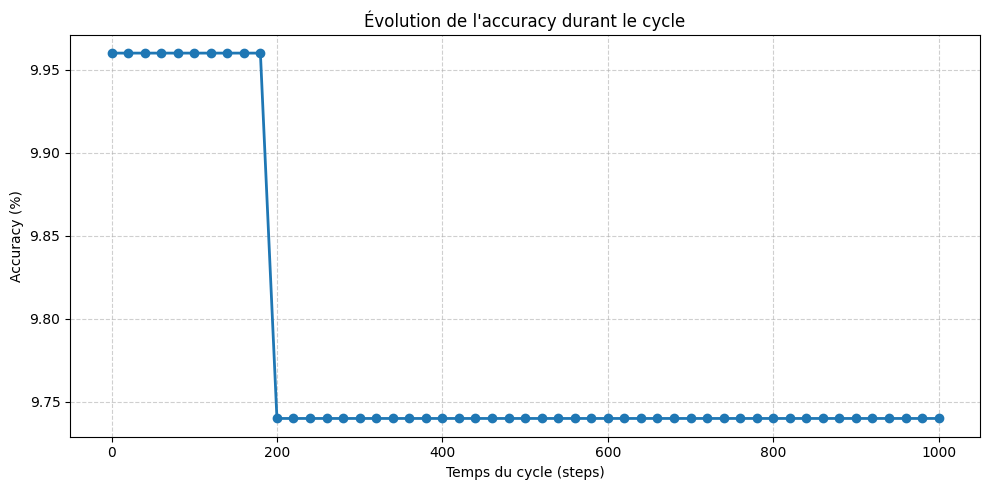

Accuracy finale du cycle : 9.74%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 3339
- Temps de calcul utile        : 265
- Temps de calcul gaspillé     : 3056
- Taux de gaspillage           : 91.52%


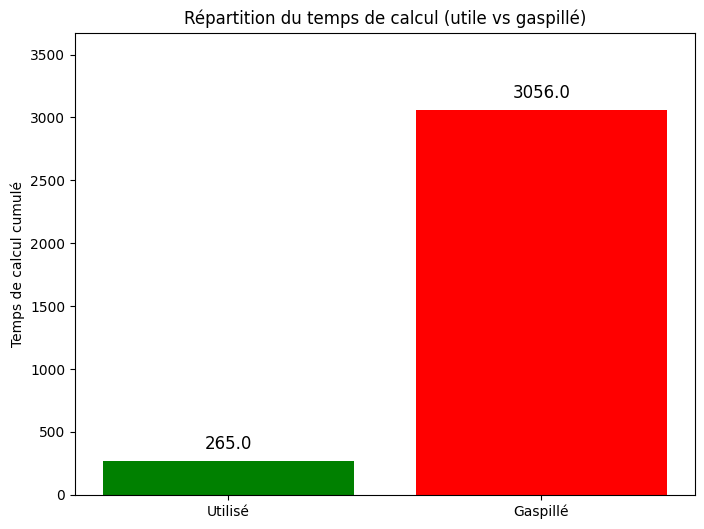


===== Cycle 2 / 2 =====


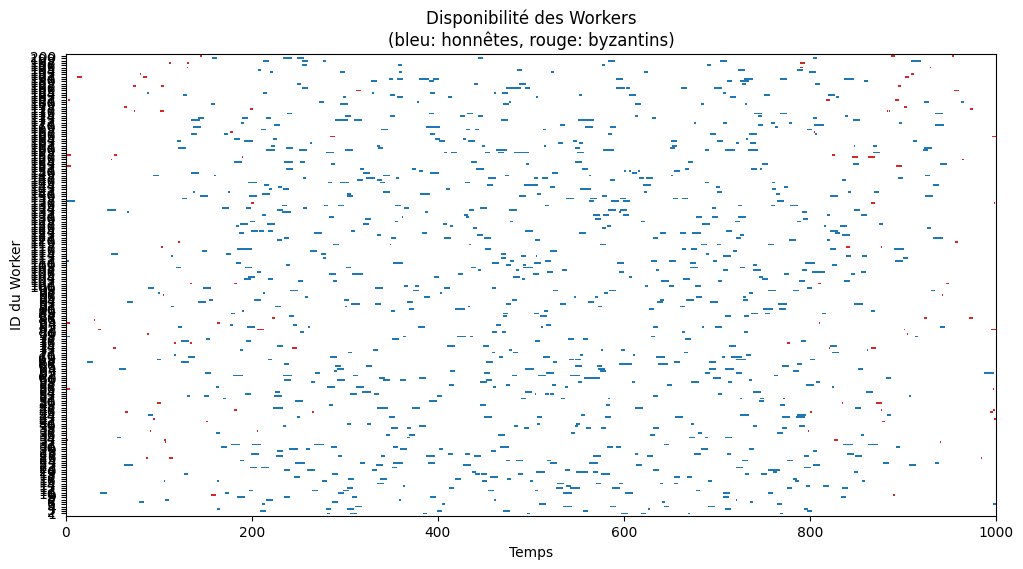

Nombre de mises à jour du modèle durant le cycle : 9


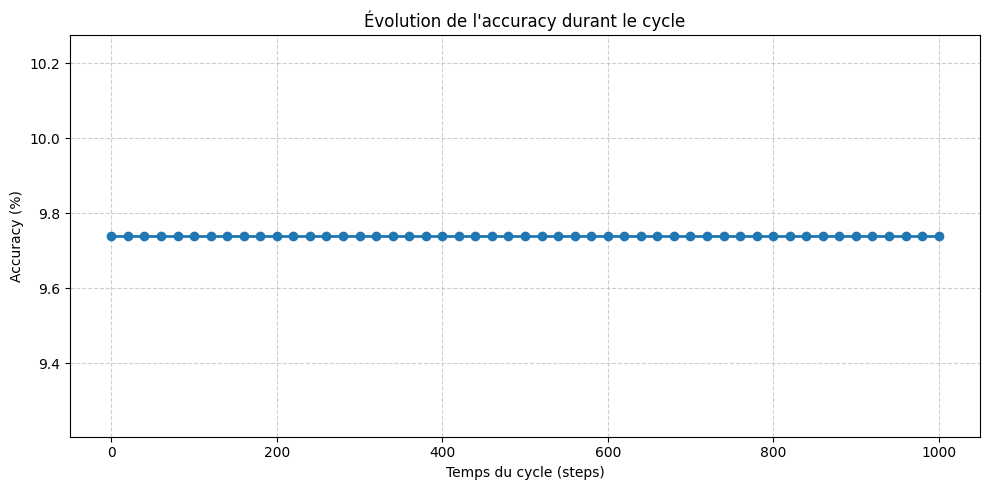

Accuracy finale du cycle : 9.74%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 6579
- Temps de calcul utile        : 526
- Temps de calcul gaspillé     : 6032
- Taux de gaspillage           : 91.69%


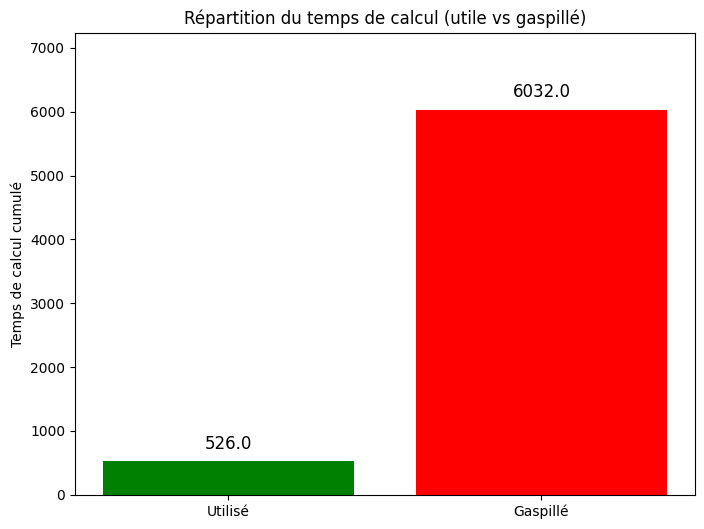

Run final - Accuracy après 2 cycles : 9.74%

Accuracy moyenne sur tous les runs : 9.74%
PreAgg: NoPreAgg, Aggregator: average, Byzantine ratio: 20%, Accuracy: 9.74%

===== Cycle 1 / 2 =====


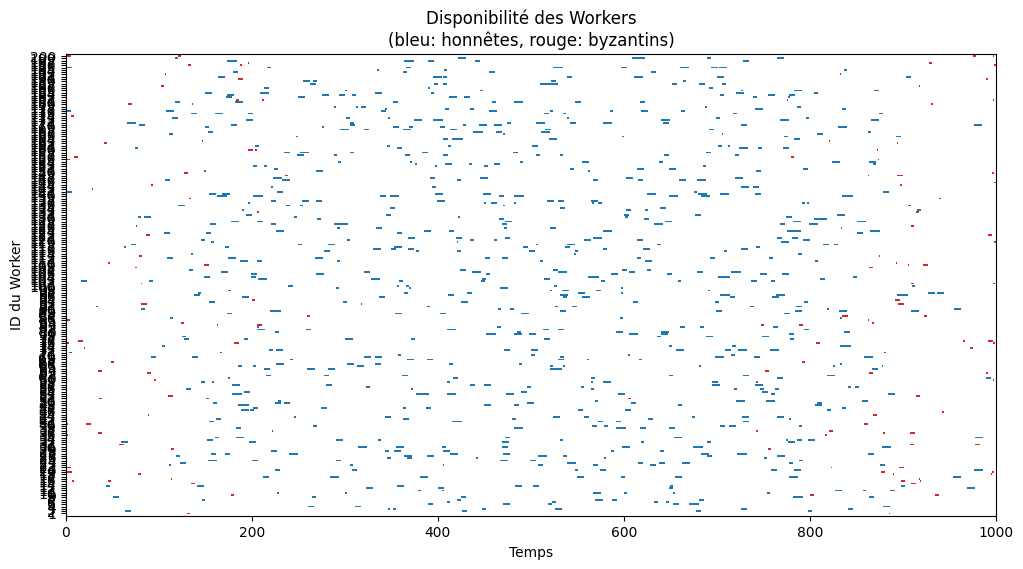

Nombre de mises à jour du modèle durant le cycle : 9


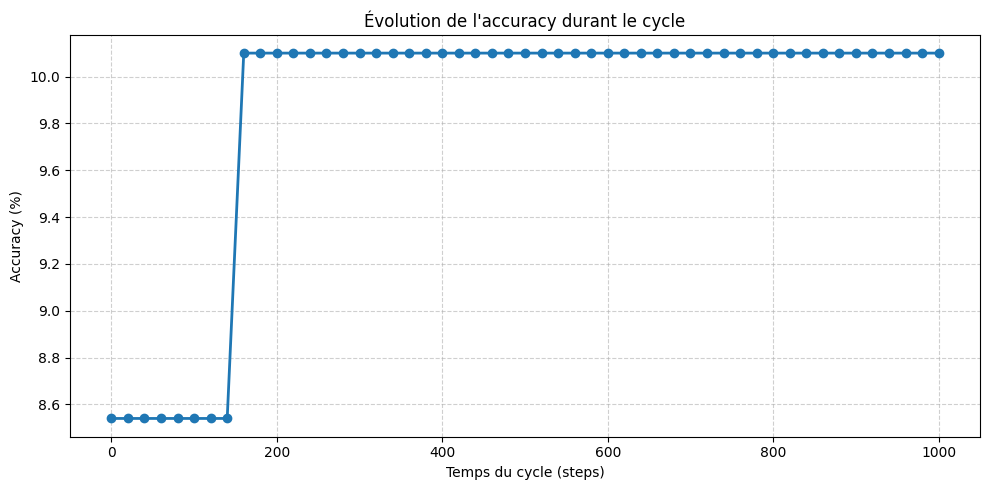

Accuracy finale du cycle : 10.10%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 3043
- Temps de calcul utile        : 252
- Temps de calcul gaspillé     : 2782
- Taux de gaspillage           : 91.42%


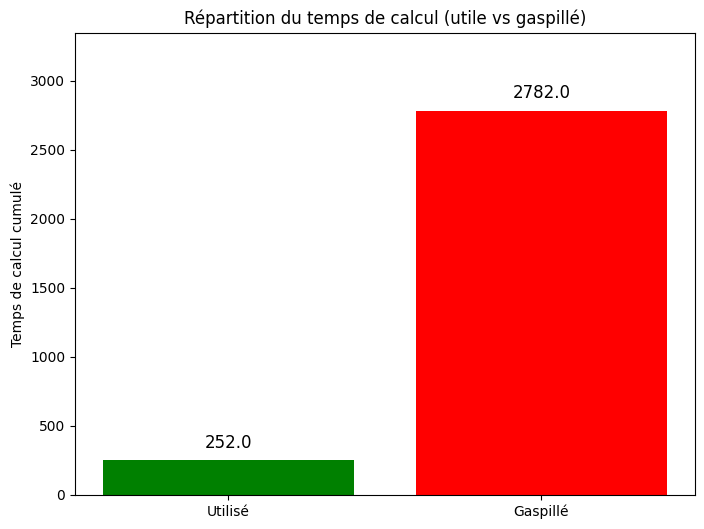


===== Cycle 2 / 2 =====


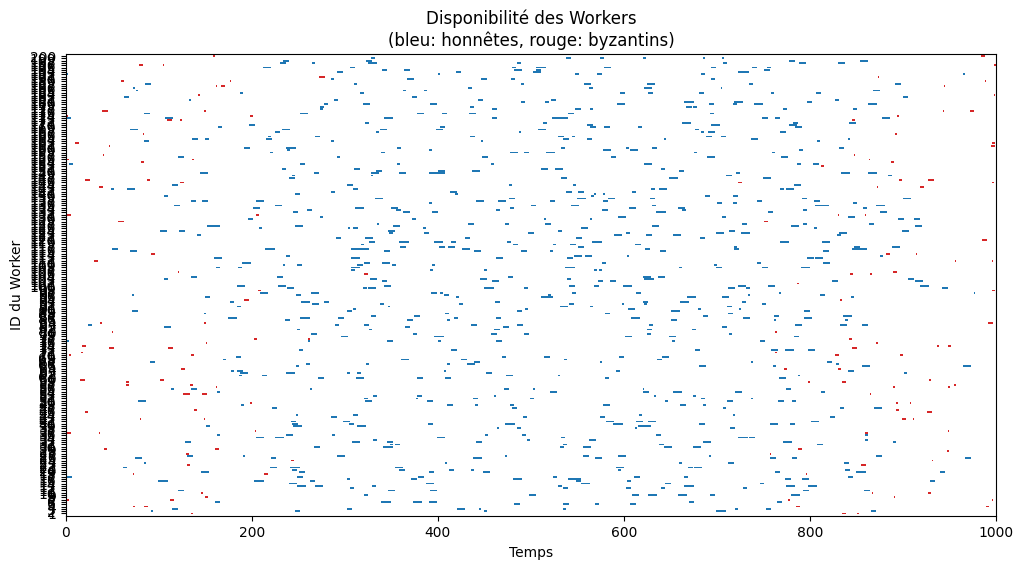

Nombre de mises à jour du modèle durant le cycle : 9


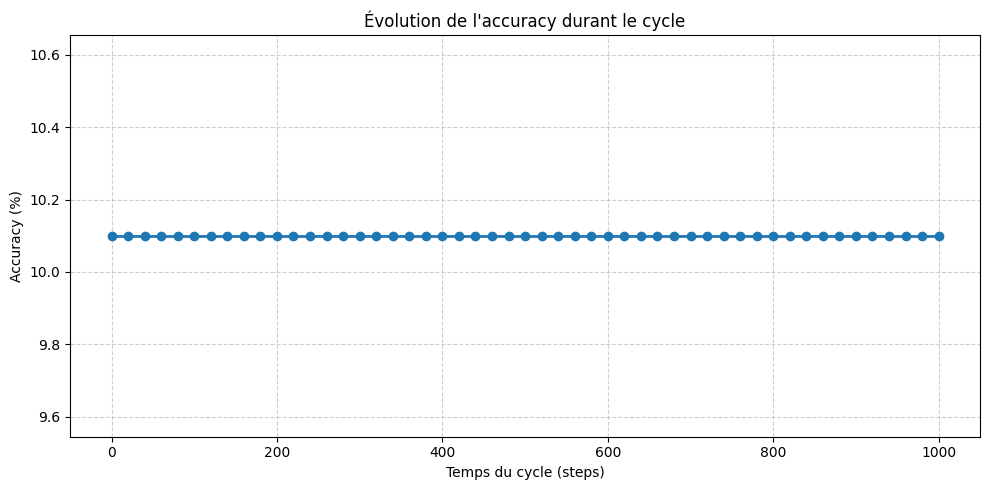

Accuracy finale du cycle : 10.10%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 6142
- Temps de calcul utile        : 503
- Temps de calcul gaspillé     : 5612
- Taux de gaspillage           : 91.37%


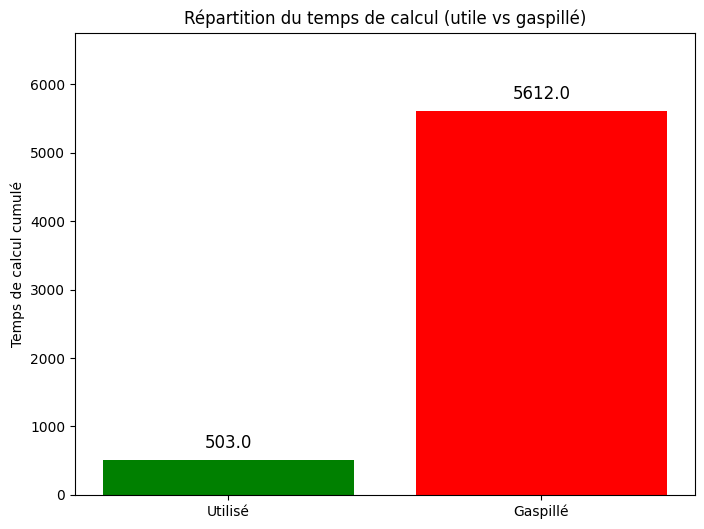

Run final - Accuracy après 2 cycles : 10.10%

Accuracy moyenne sur tous les runs : 10.10%
PreAgg: NoPreAgg, Aggregator: average, Byzantine ratio: 30%, Accuracy: 10.10%

===== Cycle 1 / 2 =====


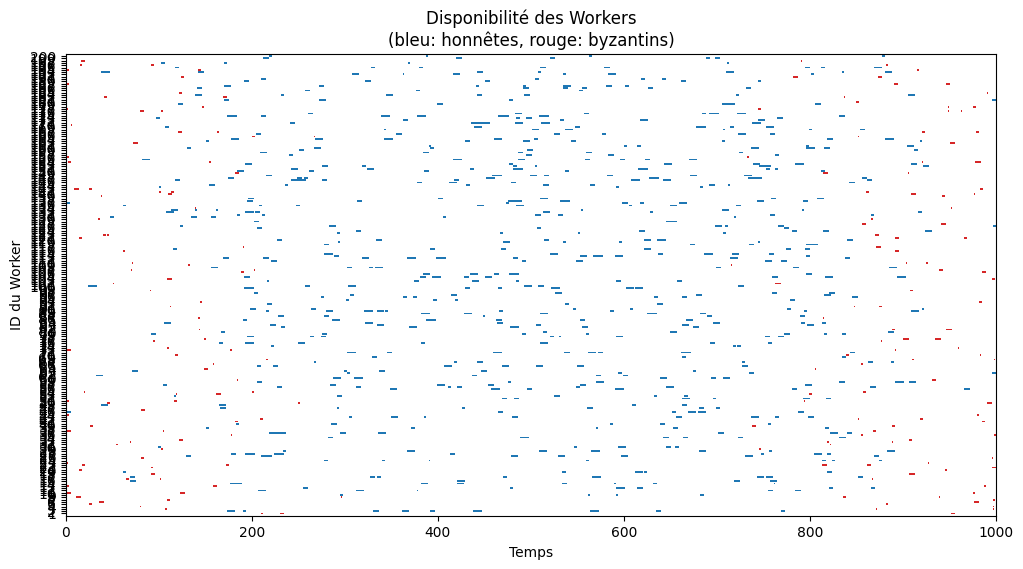

Nombre de mises à jour du modèle durant le cycle : 8


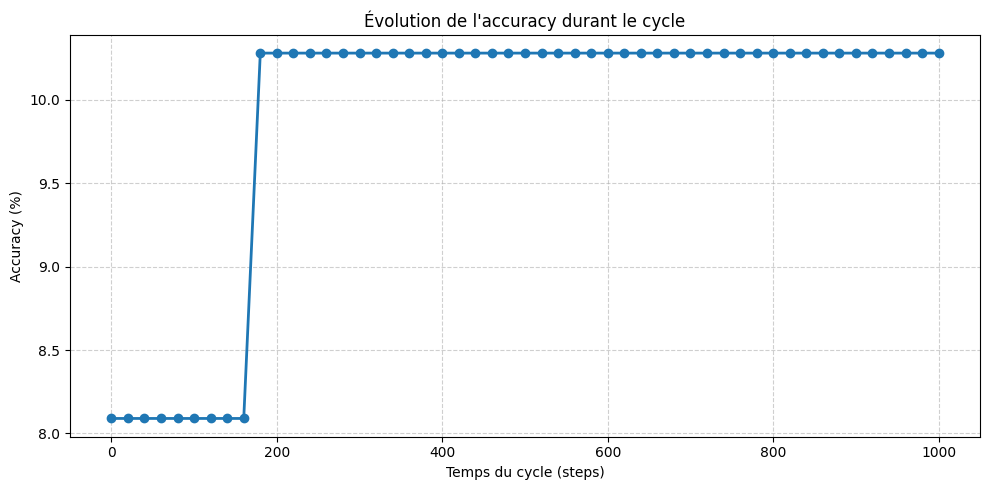

Accuracy finale du cycle : 10.28%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 2834
- Temps de calcul utile        : 226
- Temps de calcul gaspillé     : 2589
- Taux de gaspillage           : 91.35%


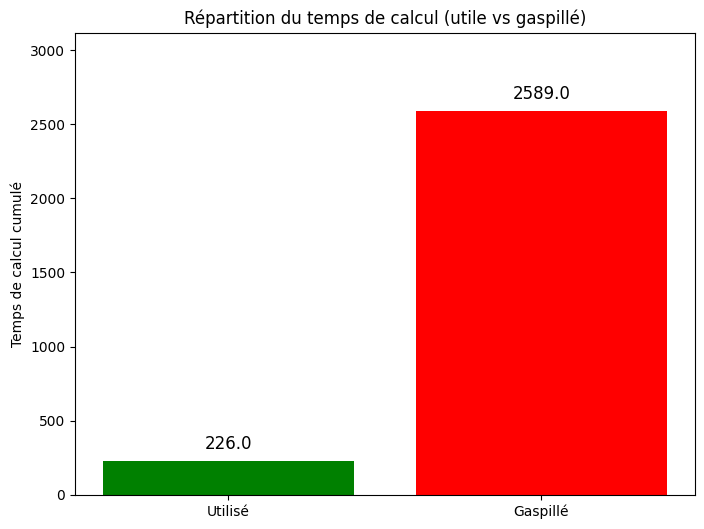


===== Cycle 2 / 2 =====


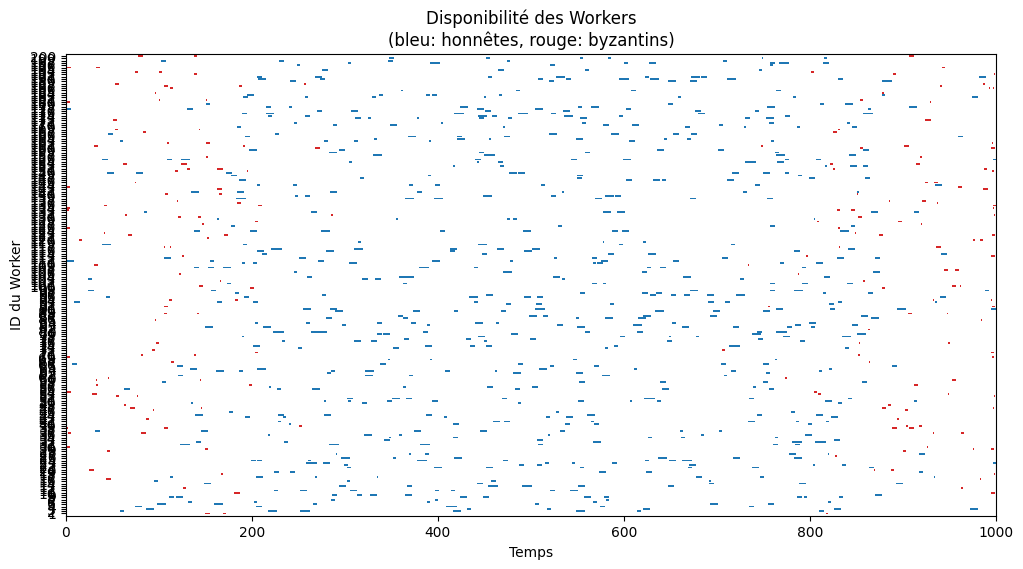

Nombre de mises à jour du modèle durant le cycle : 8


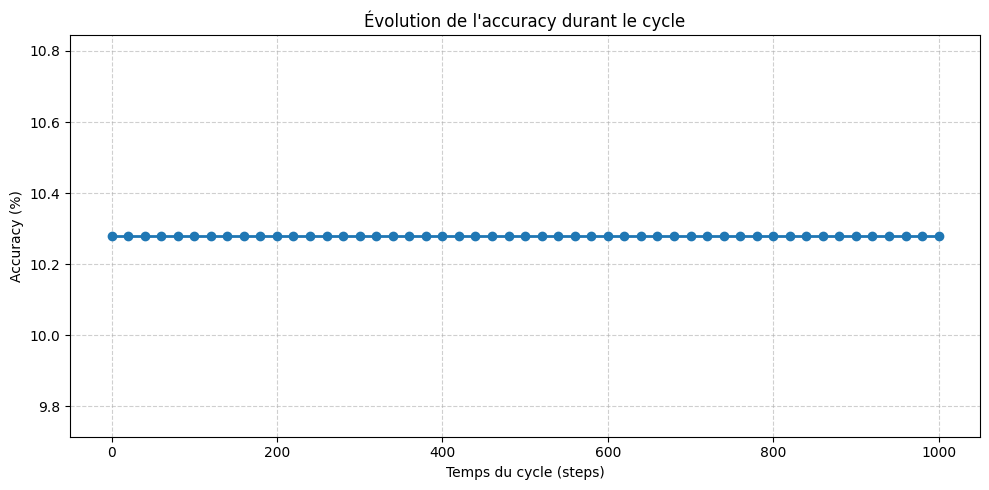

Accuracy finale du cycle : 10.28%

📊 Rapport de temps de calcul :
- Temps de calcul brut total : 5659
- Temps de calcul utile        : 461
- Temps de calcul gaspillé     : 5176
- Taux de gaspillage           : 91.46%


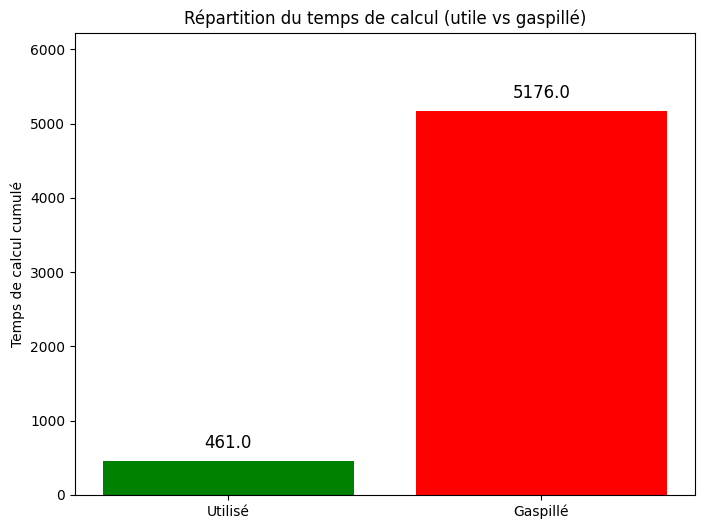

Run final - Accuracy après 2 cycles : 10.28%

Accuracy moyenne sur tous les runs : 10.28%
PreAgg: NoPreAgg, Aggregator: average, Byzantine ratio: 40%, Accuracy: 10.28%


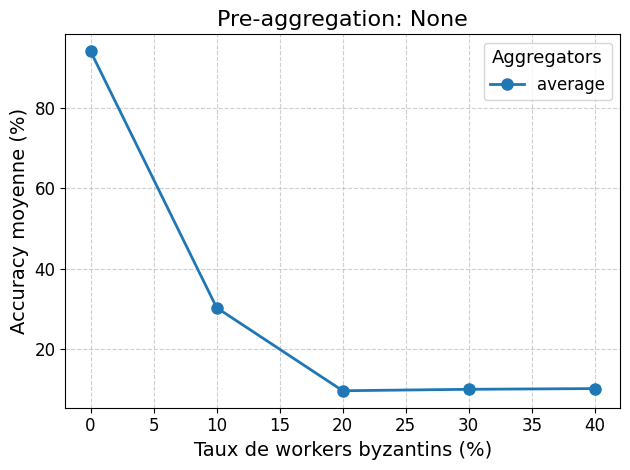

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import byzfl
import torch.nn.functional as F

# ------------------------------------------------------------------------------
# Fusionne les intervalles qui se chevauchent ou sont adjacents.
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_gaussian_availability(total_time_steps, worker_id, num_workers, std_dev_ratio=0.1, min_processing_time=3):
    """
    Disponibilité honnête : 3 pics durant les heures pleines.
    """
    peak_means = [0.25, 0.5, 0.75]  # en proportion du total
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in peak_means:
        mean = int(mean_ratio * total_time_steps)
        intensity = random.choice([1, 2, 3])
        for _ in range(intensity):
            start_time = int(np.random.normal(loc=mean, scale=std_dev))
            start_time = max(0, min(start_time, total_time_steps - min_processing_time))
            max_extra = 2 * intensity
            duration = random.randint(min_processing_time, min(min_processing_time + max_extra, total_time_steps - start_time))
            end_time = start_time + duration
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

def generate_gaussian_byzantine_availability(total_time_steps, worker_id, num_workers, std_dev_ratio=0.08, min_processing_time=2):
    """
    Disponibilité byzantine : pics dans les heures creuses uniquement.
    """
    off_peak_means = [0.1, 0.9]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in off_peak_means:
        mean = int(mean_ratio * total_time_steps)
        intensity = random.choice([1, 1, 2])
        for _ in range(intensity):
            start_time = int(np.random.normal(loc=mean, scale=std_dev))
            start_time = max(0, min(start_time, total_time_steps - min_processing_time))
            max_extra = 1 * intensity
            duration = random.randint(1, min(min_processing_time + max_extra, total_time_steps - start_time))
            end_time = start_time + duration
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

# ------------------------------------------------------------------------------
# Définition des modèles
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class LeNetLike(nn.Module):
    def __init__(self):
        super(LeNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de batch
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.sampler = SequentialSampler(self.dataset)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))

    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            # Redémarre simplement un nouvel iterateur sans reshuffle
            self.sampler = SequentialSampler(self.dataset)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Définition des Workers
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods  # Cette valeur sera régénérée à chaque cycle
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None  # (batch_id, mini_batch_idx)
    def is_available(self, current_time):
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False
    def start_computation(self, current_time, batch_info, data, targets):
        if self.current_batch_info is None or self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            return self.compute_gradient(data, targets)
        return None
    def has_finished(self, current_time):
        return self.finish_time == current_time
    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_info
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

class ByzantineWorker(Worker):
    def compute_gradient(self, data, targets):
        corrupted_gradients = {}
        for name, param in self.model.named_parameters():
            corrupted_gradients[name] = torch.full_like(param, 1e6)
        return corrupted_gradients, self.current_batch_info

# ------------------------------------------------------------------------------
# Serveur avec vote majoritaire et suivi de compute time
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.005, verbose=False,
                 aggregation_strategy='trimmed_mean', f=0, preagg=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LeNetLike().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_complete_batch = None
        self.current_batch_id = 0
        # Pour chaque mini-batch, on stocke une liste de gradients en attente de vote
        self.received_gradients = {}
        self.verbose = verbose
        self.aggregation_strategy = aggregation_strategy
        self.f = f
        self.preagg = preagg
        self.update_count = 0  # Dans Server.__init__()
        # Suivi du temps de calcul
        self.total_raw_compute_time = 0          # Somme de tous les temps de calcul reçus
        self.total_useful_compute_time = 0       # Temps de calcul utile (celui du gradient retenu)
        self.total_waste_compute_time = 0        # Temps de calcul gaspillé (celui des gradients rejetés)
        self.accepted_mini_batches = 0
        self.useful_processing_times = []

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_complete_batch = (data, targets)
        self.current_batch_id += 1
        num_samples = data.size(0)
        mini_batches = []
        for i in range(0, num_samples, self.mini_batch_size):
            mini_data = data[i: i + self.mini_batch_size]
            mini_targets = targets[i: i + self.mini_batch_size]
            mini_batches.append((mini_data, mini_targets))
        self.current_mini_batches = {i: mini_batches[i] for i in range(len(mini_batches))}
        self.received_gradients = {}
        if self.verbose:
            print(f"[Temps {current_time}] Batch complet {self.current_batch_id} divisé en {len(mini_batches)} mini-batches.")

    def register_gradient(self, gradients, batch_info, worker_id, current_time, worker_processing_time):
        batch_id, mini_idx = batch_info
        if batch_id != self.current_batch_id:
            return
        # Si le mini-batch a déjà un gradient validé, on ignore la nouvelle soumission
        if mini_idx in self.received_gradients and isinstance(self.received_gradients[mini_idx], dict):
            return

        # Mise à jour du temps de calcul brut
        self.total_raw_compute_time += worker_processing_time

        if mini_idx not in self.received_gradients:
            self.received_gradients[mini_idx] = []
        # Stocke (gradient, worker_id, worker_processing_time)
        self.received_gradients[mini_idx].append((gradients, worker_id, worker_processing_time))
        if self.verbose:
            print(f"[Temps {current_time}] Gradient reçu pour mini-batch {mini_idx} par worker {worker_id} (temps: {worker_processing_time}).")
        # Paramètres du vote majoritaire
        k = 10  # nombre de gradients attendus pour le vote dans ce mini-batch
        t = (k // 2) + 1  # seuil de vote (au moins t gradients identiques)

        if len(self.received_gradients[mini_idx]) == k:
            grad_tuples = self.received_gradients[mini_idx]  # Liste de tuples (gradient, worker_id, processing_time)
            grads_list = [item[0] for item in grad_tuples]
            if self._vote_majority_equality(grads_list, t):
                accepted_gradient = self._select_majority_gradient(grads_list, t)
                # Recherche du premier gradient égal au gradient accepté
                accepted_index = None
                for idx, (g, wid, ptime) in enumerate(grad_tuples):
                    if self._gradients_are_equal(g, accepted_gradient):
                        accepted_index = idx
                        break
                if accepted_index is not None:
                    accepted_processing_time = grad_tuples[accepted_index][2]
                    waste_processing_time = sum(gt[2] for j, gt in enumerate(grad_tuples) if j != accepted_index)
                    self.total_useful_compute_time += accepted_processing_time
                    self.total_waste_compute_time += waste_processing_time
                    self.received_gradients[mini_idx] = accepted_gradient  # On remplace par le gradient retenu
                    if self.verbose:
                        print(f"[Temps {current_time}] Mini-batch {mini_idx} accepté par vote majoritaire.")
                else:
                    # Cas rare : on traite comme échec
                    total_ptime = sum(gt[2] for gt in grad_tuples)
                    self.total_waste_compute_time += total_ptime
                    if self.verbose:
                        print(f"[Temps {current_time}] Erreur lors du vote pour mini-batch {mini_idx}.")
                    del self.received_gradients[mini_idx]
            else:
                # Vote échoué : tous les temps sont gaspillés
                total_ptime = sum(gt[2] for gt in grad_tuples)
                self.total_waste_compute_time += total_ptime
                if self.verbose:
                    print(f"[Temps {current_time}] Rejet du mini-batch {mini_idx} par vote majoritaire, gradients non identiques.")
                del self.received_gradients[mini_idx]

    def _gradients_are_equal(self, grad1, grad2, rtol=1e-5, atol=1e-8):
        # Compare deux dictionnaires de gradients
        for key in grad1:
            if not torch.allclose(grad1[key], grad2[key], rtol=rtol, atol=atol):
                return False
        return True

    def _vote_majority_equality(self, grads, t):
        counts = [0] * len(grads)
        for i in range(len(grads)):
            for j in range(len(grads)):
                if self._gradients_are_equal(grads[i], grads[j]):
                    counts[i] += 1
        return max(counts) >= t

    def _select_majority_gradient(self, grads, t):
        for i, g in enumerate(grads):
            cnt = 0
            for other in grads:
                if self._gradients_are_equal(g, other):
                    cnt += 1
            if cnt >= t:
                return g
        # Sinon, on retourne la moyenne
        aggregated = {}
        for key in grads[0]:
            aggregated[key] = torch.mean(torch.stack([g[key] for g in grads]), dim=0)
        return aggregated

    def aggregate_and_update(self):
        # Vérifie que chaque mini-batch a bien un gradient accepté (de type dict)
        if len(self.received_gradients) != len(self.current_mini_batches):
            if self.verbose:
                print("Attention : tous les mini-batches n'ont pas été traités.")
            return False

        for idx in self.current_mini_batches:
            if idx not in self.received_gradients or not isinstance(self.received_gradients[idx], dict):
                if self.verbose:
                    print(f"Mini-batch {idx} n'a pas encore un gradient accepté.")
                return False

        aggregated_gradients = {}
        self.f = 4
        if self.preagg == "NNM":
            preaggregator = byzfl.NNM(f=self.f)
        elif self.preagg == "Bucketing":
            preaggregator = byzfl.Bucketing(s=1)
        elif self.preagg == "ARC":
            preaggregator = byzfl.ARC(f=self.f)
        else:
            preaggregator = None

        for name, param in self.model.named_parameters():
            grads = [self.received_gradients[idx][name] for idx in self.current_mini_batches]
            grads_tensor = torch.stack(grads)
            original_shape = grads_tensor.shape[1:]
            grads_tensor_flat = grads_tensor.view(grads_tensor.size(0), -1)
            n = grads_tensor_flat.shape[0]
            effective_f = max(self.f, (n // 2) - 1)
            if preaggregator is not None:
                try:
                    preagg_flat = preaggregator(grads_tensor_flat)
                except Exception as e:
                    print(f"Erreur de pré-agrégation ({self.preagg}): {e}")
                    preagg_flat = grads_tensor_flat
            else:
                preagg_flat = grads_tensor_flat
            if self.aggregation_strategy == "trimmed_mean":
                aggregator = byzfl.TrMean(f=effective_f)
            elif self.aggregation_strategy == "multi_krum":
                aggregator = byzfl.MultiKrum(f=effective_f)
            elif self.aggregation_strategy == "geometric_median":
                aggregator = byzfl.GeometricMedian()
            elif self.aggregation_strategy == "average":
                aggregator = byzfl.Average()
            elif self.aggregation_strategy == "meamed":
                aggregator = byzfl.Meamed(f=effective_f)
            else:
                raise ValueError(f"Stratégie d’agrégation inconnue : {self.aggregation_strategy}")
            agg_flat = aggregator(preagg_flat)
            aggregated_gradients[name] = agg_flat.view(original_shape)
        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = aggregated_gradients[name]
        self.optimizer.step()
        if self.verbose:
            print(f"Modèle mis à jour avec le batch complet {self.current_batch_id}.")
        return True

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

    def report_compute_metrics(self):
        total = self.total_raw_compute_time
        useful = self.total_useful_compute_time
        waste = self.total_waste_compute_time
        waste_rate = 100 * waste / total if total > 0 else 0

        print("\n📊 Rapport de temps de calcul :")
        print(f"- Temps de calcul brut total : {total}")
        print(f"- Temps de calcul utile        : {useful}")
        print(f"- Temps de calcul gaspillé     : {waste}")
        print(f"- Taux de gaspillage           : {waste_rate:.2f}%")

        # Création de l'histogramme
        categories = ['Utilisé', 'Gaspillé']
        times = [useful, waste]

        plt.figure(figsize=(8,6))
        bars = plt.bar(categories, times, color=['green', 'red'])
        plt.title("Répartition du temps de calcul (utile vs gaspillé)")
        plt.ylabel("Temps de calcul cumulé")
        plt.ylim(0, total * 1.1)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, height + total * 0.02, f'{height:.1f}', ha='center', va='bottom', fontsize=12)
        plt.show()

# ------------------------------------------------------------------------------
# Fonction pour régénérer la disponibilité des workers pour un nouveau cycle (jour)
def regenerate_worker_availability(workers, total_time_steps, num_workers):
    for worker in workers:
        if isinstance(worker, ByzantineWorker):
            worker.availability_periods = generate_gaussian_byzantine_availability(
                total_time_steps, worker.worker_id, num_workers, min_processing_time=worker.processing_time)
        else:
            worker.availability_periods = generate_gaussian_availability(
                total_time_steps, worker.worker_id, num_workers, min_processing_time=worker.processing_time)

# ------------------------------------------------------------------------------
# Simulation d'apprentissage fédéré pour un cycle (une journée)
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=1000):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps  # steps par cycle (jour)
        self.global_time = 0
        self.in_progress_workers = []

    def run(self, verbose=False, eval_interval=10):
        if verbose:
            print("Démarrage du cycle...")
        self.server.get_new_complete_batch(self.global_time)

        accuracy_over_time = []
        time_points = []

        # redondance
        k = 10  

        while self.global_time < self.total_time_steps:
            if verbose:
                print(f"\n[Cycle - Temps {self.global_time}]")

            # Mise à jour des workers en cours
            finished_workers = []
            for worker in self.in_progress_workers:
                if worker.has_finished(self.global_time):
                    mini_idx = worker.current_batch_info[1]
                    gradients, batch_info = worker.compute_gradient(*self.server.current_mini_batches[mini_idx])
                    self.server.register_gradient(gradients, batch_info, worker.worker_id,
                                                  self.global_time, worker.processing_time)
                    finished_workers.append(worker)
            for worker in finished_workers:
                self.in_progress_workers.remove(worker)
                worker.current_batch_info = None

            # Agrégation si tous les mini-batches ont un gradient accepté
            if len(self.server.received_gradients) == len(self.server.current_mini_batches):
                if self.server.aggregate_and_update():
                    self.server.update_count += 1
                    self.server.get_new_complete_batch(self.global_time)
                    self.in_progress_workers = []

            # Planification des mini-batches avec redondance
            available_workers = [w for w in self.workers if w.is_available(self.global_time)
                                 and w not in self.in_progress_workers]
            for mini_idx in sorted(self.server.current_mini_batches.keys()):
                if mini_idx in self.server.received_gradients and isinstance(self.server.received_gradients[mini_idx], dict):
                    continue
                current_count = (len(self.server.received_gradients.get(mini_idx, []))
                                 if mini_idx in self.server.received_gradients else 0)
                while current_count < k and available_workers:
                    worker = available_workers.pop(0)
                    data, targets = self.server.current_mini_batches[mini_idx]
                    worker.start_computation(self.global_time, (self.server.current_batch_id, mini_idx),
                                             data, targets)
                    self.in_progress_workers.append(worker)
                    current_count += 1
                    if verbose:
                        print(f"[Cycle - Temps {self.global_time}] Mini-batch {mini_idx} envoyé au worker {worker.worker_id} (instance {current_count}/{k}).")

            # Évaluation périodique
            if self.global_time % eval_interval == 0:
                acc = self.server.evaluate(self.test_loader)
                accuracy_over_time.append(acc)
                time_points.append(self.global_time)
                if verbose:
                    print(f"[Cycle - Temps {self.global_time}] Accuracy test = {acc:.2f}%")

            self.global_time += 1

        self.plot_worker_availability()
        print(f"Nombre de mises à jour du modèle durant le cycle : {self.server.update_count}")
        self.server.update_count = 0

        # Évaluation finale du cycle
        final_acc = self.server.evaluate(self.test_loader)
        accuracy_over_time.append(final_acc)
        time_points.append(self.global_time)

        plt.figure(figsize=(10, 5))
        plt.plot(time_points, accuracy_over_time, marker='o', linewidth=2)
        plt.title("Évolution de l'accuracy durant le cycle")
        plt.xlabel("Temps du cycle (steps)")
        plt.ylabel("Accuracy (%)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        print(f"Accuracy finale du cycle : {final_acc:.2f}%")
        return final_acc

    def plot_worker_availability(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        for worker in self.workers:
            color = "tab:red" if isinstance(worker, ByzantineWorker) else "tab:blue"
            for (start, end) in worker.availability_periods:
                ax.broken_barh([(start, end - start)], (worker.worker_id - 0.4, 0.8), facecolors=color)
        ax.set_xlabel("Temps")
        ax.set_ylabel("ID du Worker")
        ax.set_title("Disponibilité des Workers\n(bleu: honnêtes, rouge: byzantins)")
        ax.set_xlim(0, self.total_time_steps)
        max_worker_id = max(worker.worker_id for worker in self.workers)
        ax.set_ylim(0, max_worker_id + 1)
        ax.set_yticks(range(1, max_worker_id + 1))
        plt.show()

# ------------------------------------------------------------------------------
# Fonction d'exécution d'une expérience sur plusieurs cycles (jours)
def create_workers(num_worker, byzantine_ratio, steps_per_cycle, server):
    """
    Fonction auxiliaire pour créer une liste de workers (honnêtes et byzantins)
    pour un cycle donné.
    """
    workers = []
    num_byzantine = int(num_worker * byzantine_ratio)
    # Sélectionne aléatoirement les indices des workers byzantins
    byzantine_indices = set(random.sample(range(1, num_worker + 1), num_byzantine))
    for i in range(1, num_worker + 1):
        processing_time = random.randint(2, 5)
        if i in byzantine_indices:
            availability = generate_gaussian_byzantine_availability(
                steps_per_cycle, worker_id=i, num_workers=num_worker, min_processing_time=processing_time)
            workers.append(ByzantineWorker(server.model, server.device, i, availability, processing_time))
        else:
            availability = generate_gaussian_availability(
                steps_per_cycle, worker_id=i, num_workers=num_worker, min_processing_time=processing_time)
            workers.append(Worker(server.model, server.device, i, availability, processing_time))
    return workers

def run_experiment(num_cycles=3, num_runs=1, steps_per_cycle=1000, byzantine_ratio=0.0,
                   aggregation_strategy='trimmed_mean', preagg=None):
    accuracy_list = []
    num_worker = 200
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    for run in range(num_runs):
        # Le serveur est créé une seule fois pour conserver l'historique d'apprentissage
        server = Server(train_dataset, batch_size=640, mini_batch_size=64, verbose=False,
                        aggregation_strategy=aggregation_strategy, preagg=preagg)
        cycle_accuracies = []
        for cycle in range(num_cycles):
            print(f"\n===== Cycle {cycle+1} / {num_cycles} =====")
            # Recréer (réinitialiser) les workers pour chaque cycle
            workers = create_workers(num_worker, byzantine_ratio, steps_per_cycle, server)
            # Création d'un nouveau simulateur pour le cycle courant
            simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=steps_per_cycle)
            cycle_acc = simulator.run(verbose=False, eval_interval=20)
            cycle_accuracies.append(cycle_acc)
            # Affichage du rapport de temps de calcul pour le cycle courant
            server.report_compute_metrics()
        final_acc = cycle_accuracies[-1]
        print(f"Run final - Accuracy après {num_cycles} cycles : {final_acc:.2f}%")
        accuracy_list.append(final_acc)
    overall_acc = np.mean(accuracy_list)
    print(f"\nAccuracy moyenne sur tous les runs : {overall_acc:.2f}%")
    return overall_acc

# ------------------------------------------------------------------------------
# Main
if __name__ == "__main__":
    preagg_methods = [None]  # Exemple: "NNM", "Bucketing", "ARC", etc.
    aggregator_methods = ["average"]  # Exemples: "trimmed_mean", "multi_krum", etc.
    byzantine_ratios = [0.0, 0.1, 0.2, 0.3, 0.4]  # Vous pouvez ajouter d'autres ratios (ex: 0.1, 0.2, ...)
    num_runs = 1
    num_cycles = 2
    steps_per_cycle = 1000

    for preagg in preagg_methods:
        plt.figure(figsize=(10, 7))
        for agg in aggregator_methods:
            results = []
            for ratio in byzantine_ratios:
                acc = run_experiment(num_cycles=num_cycles,
                                     num_runs=num_runs,
                                     steps_per_cycle=steps_per_cycle,
                                     byzantine_ratio=ratio,
                                     aggregation_strategy=agg,
                                     preagg=preagg)
                results.append(acc)
                method_name = preagg if preagg is not None else "NoPreAgg"
                print(f"PreAgg: {method_name}, Aggregator: {agg}, Byzantine ratio: {ratio*100:.0f}%, Accuracy: {acc:.2f}%")
            plt.plot([r*100 for r in byzantine_ratios], results, marker='o', linewidth=2, markersize=8, label=agg)
        title = f"Pre-aggregation: {preagg if preagg is not None else 'None'}"
        plt.xlabel("Taux de workers byzantins (%)", fontsize=14)
        plt.ylabel("Accuracy moyenne (%)", fontsize=14)
        plt.title(title, fontsize=16)
        plt.legend(title="Aggregators", fontsize=12, title_fontsize=13, loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        # plt.savefig(f"same_avail_accuracy_preagg_{preagg if preagg is not None else 'None'}.pdf", dpi=300)
        plt.show()
